In [1]:
# !pip install umap-learn

In [2]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer

import umap

In [10]:
# import model.rotator_lima3 as rotator
# subpath = '20240422.11:52:35-batch_size_1024'

# import model.rotator_multihead_local_coordinate as rotator
# subpath = '20240422.02:23:48-batch_size_1024'
# batch_num = 10000

import model.rotator_multireslima_rotating_history as rotator
subpath = '20240422.02:12:51-batch_size_1024'
subpath = '20240424.00:15:13-batch_size_1024' #rotator_lima3, triplet loss
subpath = '20240430.16:16:30-batch_size_256' # rotator_lima4_hippo, mse+multiplet, dim128, hdim32, head32, dep3
subpath = '20240502.19:17:09-batch_size_512'
subpath = '20240502.21:10:49-batch_size_64' # rotator_lima4_noClocks, msmarco, mse+multiplet, dim128, hdim32, head32, dep3
subpath = '20240502.23:36:34-batch_size_512' # noTime, cos_dist+multiplet

batch_num = 10000

In [11]:
folder_path = pathlib.Path('data/limanet/')

model = torch.load(folder_path/subpath/f'batch_{batch_num}-model.pt', map_location='cpu')

In [12]:
%time
def get_projection(representations, n_neighbors=10, methods=['euclidean', 'cosine'], n_jobs=16):
    transed_repr = {}
    for method in methods:
        reducer = umap.UMAP(n_neighbors=n_neighbors, metric=method, n_jobs=n_jobs)
        transed_repr[method] = reducer.fit_transform(representations)
    return transed_repr

complex_word_repr = model.predictor.all_word_embeddings()
word_repr = torch.concat([complex_word_repr.real, complex_word_repr.imag], dim=-1)

transed_word = get_projection(word_repr.detach().numpy())
transed_angle = get_projection(model.angle_embedding.weight.detach().numpy())

del model

CPU times: user 15 µs, sys: 2 µs, total: 17 µs
Wall time: 33.1 µs


In [13]:
dataset = datasets.load_dataset('bookcorpus')['train']
dataset[:3]

{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

In [14]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

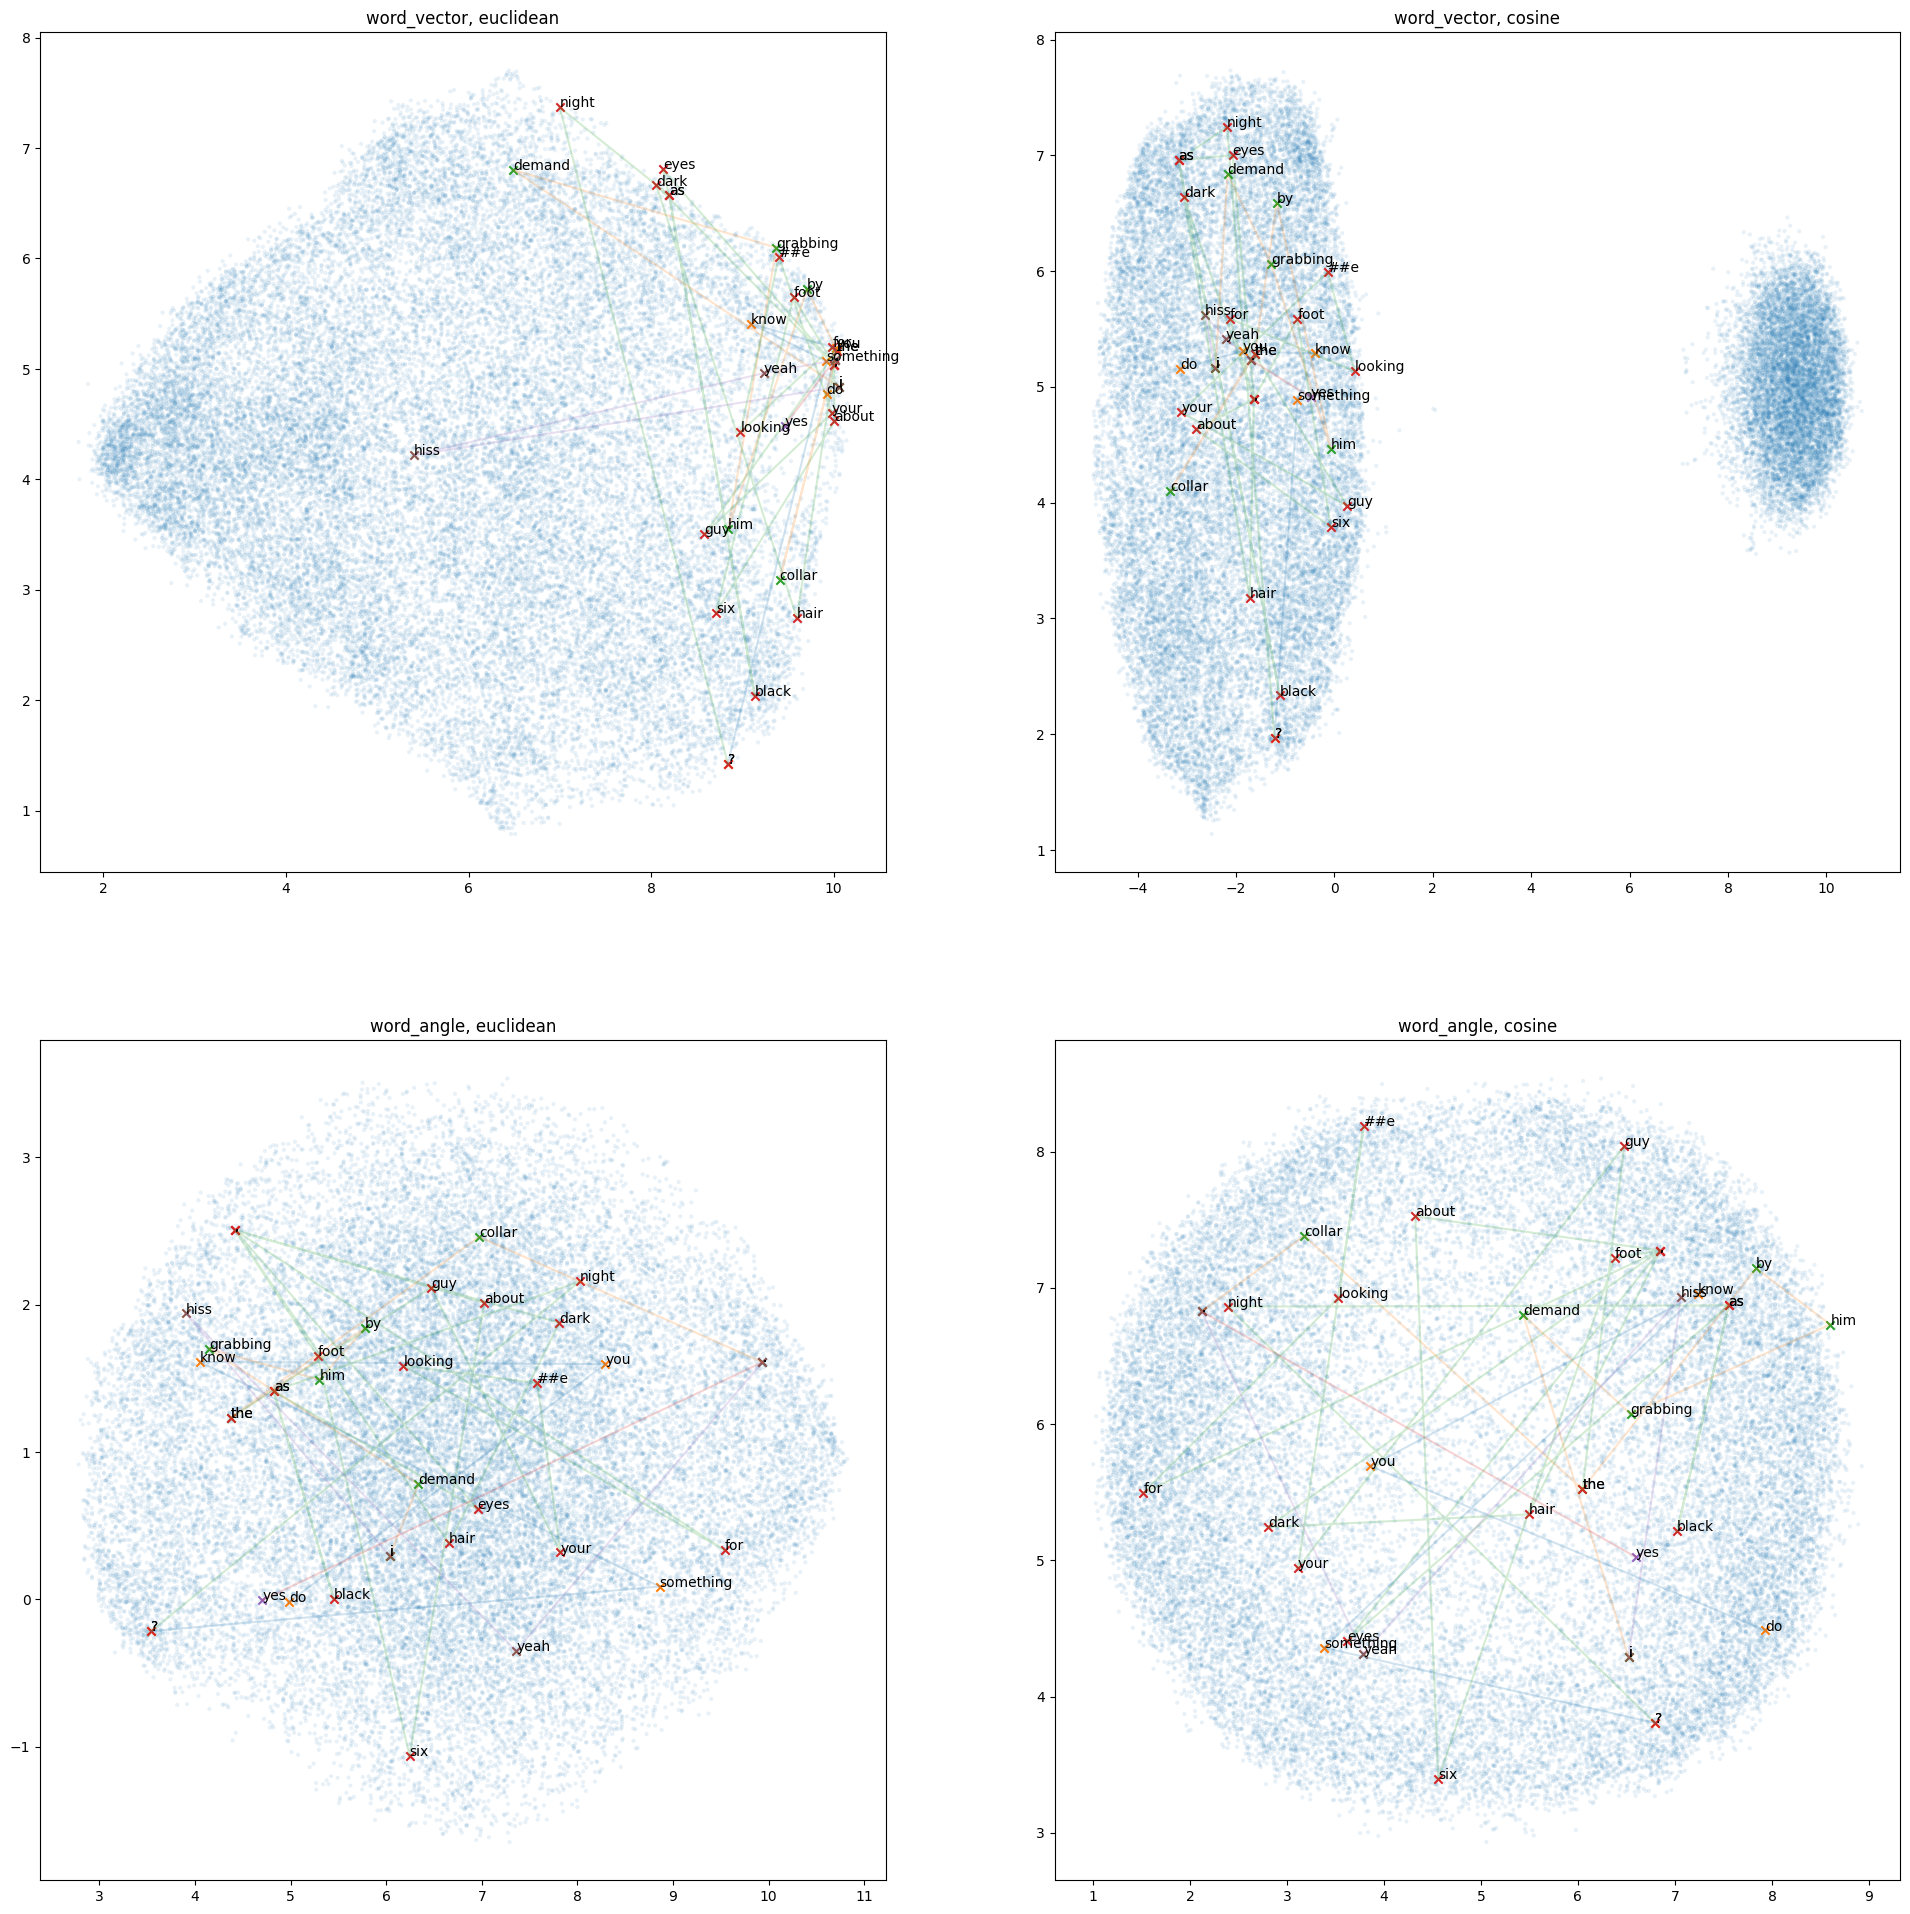

In [15]:
sampling_position = np.random.randint(0, len(dataset))


samples = dataset[sampling_position:sampling_position+5]['text']
sequences = tokenizer(samples, add_special_tokens=False)['input_ids']

representations = {
    'word_vector': transed_word,
    'word_angle': transed_angle
}
methods = ['euclidean', 'cosine']

fig, axes = plt.subplots(len(methods), len(representations), figsize=[12*len(methods),12*len(representations)])

for i, repr_name in enumerate(representations):
    for j, method in enumerate(methods):
        ax = axes[i, j]
        representation = representations[repr_name]
        ax.set_title(f'{repr_name}, {method}')
        
        ax.scatter(*representation[method].T, marker='.', edgecolors='none', alpha=.1)
        
        for seq in sequences:
            positions = representation[method][seq]
            ax.plot(*positions.T, alpha=.2)
            ax.scatter(*positions.T, marker='x')
            
            tokens = tokenizer.convert_ids_to_tokens(seq)
            
            for token, pos in zip(tokens, positions):
                # print(token, pos)
                ax.annotate(token, pos)

In [9]:
fig.savefig('image/umap.png')